In [1]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
import tensorflow as tf
from math import radians, sin, cos, sqrt, atan2
from google.colab import files

In [3]:
# Unggah dataset
uploaded = files.upload()

Saving dataset_tempat_wisata_malang.csv to dataset_tempat_wisata_malang.csv


In [4]:
# Load dataset
data = pd.read_csv("dataset_tempat_wisata_malang.csv", sep=";")

# Konversi kolom 'rating', 'latitude', dan 'longitude' menjadi float
data['rating'] = data['rating'].str.replace(',', '.').astype(float)
data['latitude'] = data['latitude'].str.replace(',', '.').astype(float)
data['longitude'] = data['longitude'].str.replace(',', '.').astype(float)

# Hapus kolom yang tidak relevan
columns_to_drop = [
    'postalCode', 'imageUrl', 'url', 'phone',
    'openingHours/0/day', 'openingHours/0/hours', 'openingHours/1/day', 'openingHours/1/hours',
    'openingHours/2/day', 'openingHours/2/hours', 'openingHours/3/day', 'openingHours/3/hours',
    'openingHours/4/day', 'openingHours/4/hours', 'openingHours/5/day', 'openingHours/5/hours',
    'openingHours/6/day', 'openingHours/6/hours'
]
data_cleaned = data.drop(columns=columns_to_drop)

# Tampilkan informasi dataset setelah penghapusan kolom
print(data_cleaned.info())

# Periksa data yang hilang
print(data_cleaned.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   placeId      200 non-null    int64  
 1   name         200 non-null    object 
 2   rating       200 non-null    float64
 3   review       200 non-null    int64  
 4   category     200 non-null    object 
 5   description  200 non-null    object 
 6   city         200 non-null    object 
 7   address      200 non-null    object 
 8   latitude     200 non-null    float64
 9   longitude    200 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 15.8+ KB
None
placeId        0
name           0
rating         0
review         0
category       0
description    0
city           0
address        0
latitude       0
longitude      0
dtype: int64


In [5]:
# Analisis jumlah tempat wisata berdasarkan kategori
category_counts = data_cleaned['category'].value_counts()
print("Jumlah tempat wisata per kategori:")
print(category_counts)

# Analisis statistik deskriptif untuk rating dan review
rating_review_stats = data_cleaned[['rating', 'review']].describe()
print(rating_review_stats)

Jumlah tempat wisata per kategori:
category
Wisata Rekreasi                  77
Wisata Alam                      45
Wisata Religi (Tempat Ibadah)    31
Wisata Edukasi                   19
Museum                           10
Wisata Budaya                     8
Taman Kota                        5
Wisata Sejarah                    5
Name: count, dtype: int64
           rating        review
count  200.000000    200.000000
mean     4.527000   3056.035000
std      0.273946   8504.797096
min      3.500000      2.000000
25%      4.400000     59.000000
50%      4.500000    353.000000
75%      4.700000   1626.000000
max      5.000000  64009.000000


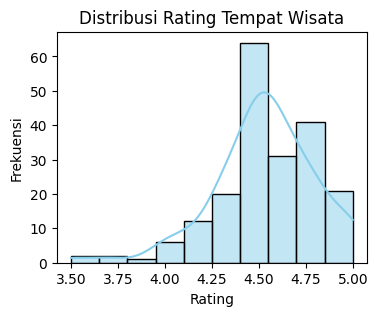

In [6]:
# Visualisasi Data
# Visualisasi distribusi rating
plt.figure(figsize=(4, 3))
sns.histplot(data_cleaned['rating'], kde=True, bins=10, color="skyblue")
plt.title("Distribusi Rating Tempat Wisata")
plt.xlabel("Rating")
plt.ylabel("Frekuensi")
plt.show()


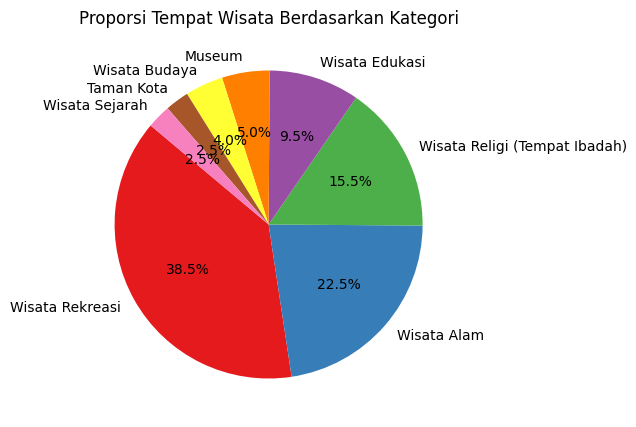

In [7]:
plt.figure(figsize=(5, 5))
category_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("Set1", len(category_counts)),
    ylabel='',
    title="Proporsi Tempat Wisata Berdasarkan Kategori"
)
plt.show()


<ipython-input-8-a0ac092c06e1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviewed_places['name'], y=top_reviewed_places['review'], palette="magma")


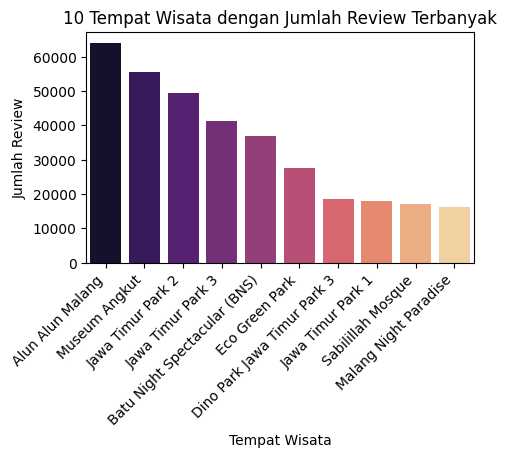

In [8]:
# Visualisasi 10 tempat wisata dengan jumlah review terbanyak
top_reviewed_places = data_cleaned.sort_values(by='review', ascending=False).head(10)
plt.figure(figsize=(5, 3))
sns.barplot(x=top_reviewed_places['name'], y=top_reviewed_places['review'], palette="magma")
plt.title("10 Tempat Wisata dengan Jumlah Review Terbanyak")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Tempat Wisata")
plt.ylabel("Jumlah Review")
plt.show()

In [9]:
# Hitung rata-rata rating (C) dari semua tempat wisata
C = data_cleaned['rating'].mean()

# Tentukan jumlah minimum review (m) untuk masuk perhitungan (contoh: persentil ke-50)
m = np.percentile(data_cleaned['review'], 50)

# Filter tempat wisata yang jumlah review-nya >= m
qualified_places = data_cleaned[data_cleaned['review'] >= m]

# Hitung Weighted Rating (WR) untuk setiap tempat wisata yang memenuhi syarat
qualified_places['score'] = (
    (qualified_places['review'] * qualified_places['rating']) + (m * C)
) / (qualified_places['review'] + m)

# Urutkan berdasarkan skor
qualified_places = qualified_places.sort_values(by='score', ascending=False)

# Tampilkan rekomendasi
print(qualified_places[['name', 'category', 'rating', 'review', 'score']])


                          name                       category  rating  review  \
179       Masjid Manarul Islam  Wisata Religi (Tempat Ibadah)     4.9    1110   
123          Sabilillah Mosque  Wisata Religi (Tempat Ibadah)     4.8   17223   
102            Hawai Waterpark                Wisata Rekreasi     4.8    8324   
104  Malang Jami' Grand Mosque  Wisata Religi (Tempat Ibadah)     4.8    6094   
49             Idjen Boulevard                    Wisata Alam     4.8    4894   
..                         ...                            ...     ...     ...   
9                Tlogomas Park                Wisata Rekreasi     4.1    1700   
171             Malang Skyland                Wisata Rekreasi     4.1    2017   
50                  Coban Rais                    Wisata Alam     4.1    5272   
4     Wendit Recreational Park                Wisata Rekreasi     4.1    7656   
12    Tarekot Kota Malang Park                Wisata Rekreasi     4.0    1323   

        score  
179  4.8100

<ipython-input-9-5939f015a127>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_places['score'] = (


In [10]:
def recommend_by_category(data, category):
    """
    Memberikan rekomendasi tempat wisata berdasarkan kategori dengan pendekatan Weighted Rating.
    Tempat wisata yang tidak memenuhi jumlah review tetap ditampilkan di urutan paling bawah.

    Args:
        data (pd.DataFrame): Dataset tempat wisata.
        category (str): Kategori tempat wisata yang dipilih pengguna.

    Returns:
        pd.DataFrame: Tempat wisata yang direkomendasikan dengan urutan sesuai Weighted Rating.
    """
    # Filter data berdasarkan kategori yang dipilih
    filtered_data = data[data['category'] == category]

    # Jika tidak ada tempat wisata dalam kategori tersebut
    if filtered_data.empty:
        print(f"Tidak ada tempat wisata dalam kategori '{category}'.")
        return pd.DataFrame()

    # Hitung rata-rata rating (C) dari semua tempat wisata dalam kategori
    C = filtered_data['rating'].mean()

    # Tentukan jumlah minimum review (m) untuk masuk perhitungan (contoh: persentil ke-50)
    m = np.percentile(filtered_data['review'], 50)

    # Filter tempat wisata yang memenuhi jumlah review >= m
    qualified_places = filtered_data[filtered_data['review'] >= m]

    # Hitung Weighted Rating (WR) untuk tempat wisata yang memenuhi syarat
    qualified_places['score'] = (
        (qualified_places['review'] * qualified_places['rating']) + (m * C)
    ) / (qualified_places['review'] + m)

    # Tempat wisata yang tidak memenuhi syarat
    unqualified_places = filtered_data[filtered_data['review'] < m]
    unqualified_places['score'] = 0  # Set nilai Weighted Rating ke 0 untuk unqualified places

    # Gabungkan keduanya dan urutkan
    all_places = pd.concat([qualified_places, unqualified_places])
    recommendations = all_places.sort_values(by='score', ascending=False)

    return recommendations[['name', 'category', 'rating', 'review', 'score']]


In [11]:
# Contoh penggunaan
category_to_recommend = "Wisata Alam"
top_recommendations = recommend_by_category(data_cleaned, category_to_recommend)

print(f"Rekomendasi tempat wisata untuk kategori '{category_to_recommend}':")
print(top_recommendations)

Rekomendasi tempat wisata untuk kategori 'Wisata Alam':
                                          name     category  rating  review  \
49                             Idjen Boulevard  Wisata Alam     4.8    4894   
163                       Pantai Batu Bengkung  Wisata Alam     4.7    2167   
166                              Pantai Ngudel  Wisata Alam     4.7    1336   
161                             Pantai Sendiki  Wisata Alam     4.6    3614   
164                        Pantai Banyu Meneng  Wisata Alam     4.6    2040   
148                       Pantai Tanjung Penyu  Wisata Alam     4.6    1720   
165                            Pantai Wonogoro  Wisata Alam     4.6     393   
146                           Gunung Panderman  Wisata Alam     4.6     338   
160                        Pantai Teluk Asmara  Wisata Alam     4.5    7957   
157                      Pantai Ngliyep Malang  Wisata Alam     4.5    4733   
169                         Pantai Parang Dowo  Wisata Alam     4.5    1035

<ipython-input-10-88c7d2e0d12d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_places['score'] = (
<ipython-input-10-88c7d2e0d12d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unqualified_places['score'] = 0  # Set nilai Weighted Rating ke 0 untuk unqualified places


In [12]:
# Inisialisasi TF-IDF Vectorizer
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)

# Latih TF-IDF pada kolom 'description'
data['description'] = data['description'].fillna('')  # Mengatasi nilai NaN jika ada
tfidf.fit(data['description'])


TfidfVectorizer(max_features=5000,
                stop_words=['yang', 'untuk', 'pada', 'ke', 'para', 'namun',
                            'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti',
                            'jika', 'jika', 'sehingga', 'kembali', 'dan',
                            'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat',
                            'harus', 'sementara', 'setelah', 'belum', 'kami',
                            'sekitar', 'bagi', ...])

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius bumi dalam kilometer
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [14]:
def recommend_similar_places_v2(place_name: str, top_n: int = 5, priority: str = "relevance"):
    """
    Merekomendasikan tempat wisata serupa berdasarkan prioritas.

    Parameters:
    - place_name: Nama tempat wisata yang dipilih.
    - top_n: Jumlah rekomendasi yang ingin ditampilkan.
    - priority: Prioritas rekomendasi ('relevance', 'distance', 'rating_review').

    Returns:
    - DataFrame dengan tempat wisata serupa yang direkomendasikan.
    """
    # Filter tempat wisata berdasarkan nama
    current_place = data[data['name'] == place_name]
    if current_place.empty:
        return f"Tempat wisata '{place_name}' tidak ditemukan."

    # Ambil data lokasi, kategori, deskripsi, rating, dan review dari tempat saat ini
    lat1, lon1 = current_place.iloc[0]['latitude'], current_place.iloc[0]['longitude']
    category_current = current_place.iloc[0]['category']
    description_current = current_place.iloc[0]['description']

    # Hitung jarak lokasi menggunakan Haversine
    data['distance'] = data.apply(
        lambda row: haversine_distance(lat1, lon1, row['latitude'], row['longitude']), axis=1
    )

    # Hitung kesamaan kategori
    data['category_similarity'] = data['category'].apply(lambda x: 1 if x == category_current else 0)

    # Hitung kesamaan deskripsi menggunakan TF-IDF dan cosine similarity
    tfidf_matrix = tfidf.transform(data['description'])
    current_description_vector = tfidf.transform([description_current])
    description_similarity = cosine_similarity(current_description_vector, tfidf_matrix).flatten()
    data['description_similarity'] = description_similarity

    # Standarisasi rating dan review
    scaler = StandardScaler()
    data[['rating_scaled', 'review_scaled']] = scaler.fit_transform(data[['rating', 'review']])

    # Tetapkan bobot berdasarkan prioritas
    if priority == "relevance":
        weight_distance = 20
        weight_category = 20
        weight_description = 55
        weight_rating_review = 5
    elif priority == "distance":
        weight_distance = 80
        weight_category = 5
        weight_description = 10
        weight_rating_review = 5
    elif priority == "rating_review":
        # Pendekatan Weighted Rating
        C = data['rating'].mean()
        m = np.percentile(data['review'], 50)
        data['weighted_rating'] = (
            (data['review'] * data['rating'] + m * C) / (data['review'] + m)
        )
        weight_distance = 10
        weight_category = 10
        weight_description = 10
        weight_rating_review = 70
    else:
        return "Prioritas tidak valid. Gunakan 'relevance', 'distance', atau 'rating_review'."

    # Hitung skor akhir berdasarkan bobot
    data['similarity_score'] = (
        (1 / (1 + data['distance'])) * weight_distance +
        data['category_similarity'] * weight_category +
        data['description_similarity'] * weight_description
    )

    # Jika menggunakan prioritas 'rating_review', tambahkan Weighted Rating
    if priority == "rating_review":
        data['similarity_score'] += data['weighted_rating'] * weight_rating_review

    # Filter tempat wisata lain (kecuali tempat yang sedang dibuka) dan urutkan berdasarkan skor
    similar_places = data[data['name'] != place_name].sort_values('similarity_score', ascending=False).head(top_n)

    # Tampilkan kolom yang relevan
    result = similar_places[['name', 'category', 'rating', 'review', 'distance', 'similarity_score']]
    return result


In [17]:
# Contoh penggunaan
place_name = "Malang Night Paradise"
priority = "distance"  # Pilihan: "relevance", "distance", "rating_review"
recommended_places = recommend_similar_places_v2(place_name=place_name, top_n=25, priority=priority)
print(recommended_places)

                                          name                       category  \
102                            Hawai Waterpark                Wisata Rekreasi   
56                        Kampung Semar Malang                Wisata Rekreasi   
28                               Kendedes Park                Wisata Rekreasi   
75                                Kebun Murbei                    Wisata Alam   
8                   Polowijen Cultural Village                  Wisata Budaya   
84                                Offroad Batu                Wisata Rekreasi   
4                     Wendit Recreational Park                Wisata Rekreasi   
26                        Water Park Tirtasani                Wisata Rekreasi   
73                          Wisata kali djaeng                    Wisata Alam   
79           Jembatan sendang Widodaren Wendit                Wisata Rekreasi   
123                          Sabilillah Mosque  Wisata Religi (Tempat Ibadah)   
83                     Talan